# DEMO: Two-qubit QAE instance (by Hannah Sim)

In this demo, we compress a two-qubit data set such that we have its (lossy) description using one qubit.

We show the state preparation and training circuits below (circuits for both training schemes are shown but in this notebook, we run the "full with reset" method):

<img src="../images/two_qubit_circuits.png" width="500">

We first generate the data set by varying $\phi$ (40 equally-spaced points from $\frac{-\pi}{2}$ to $\frac{\pi}{2}$). Then, a single-parameter circuit is used to find the 2-1-2 map. Looking at the circuit, the minimum should be when $\theta = 0$.


In [10]:
# Import modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.optimize

from pyquil.gates import *
from pyquil import Program
from pyquil.api import WavefunctionSimulator

from qcompress.qae_engine import *
from qcompress.utils import *

global pi
pi = np.pi

ModuleNotFoundError: No module named 'qcompress'

## QAE Settings

In the cell below, we enter the settings for the QAE.

__NOTE__: Because QCompress was designed to run on the quantum device (as well as the simulator), we need to anticipate nontrival mappings between abstract qubits and physical qubits. The dictionaries `q_in`,  `q_latent`, and `q_refresh` are abstract-to-physical qubit mappings for the input, latent space, and refresh qubits respectively. A cool plug-in/feature to add would be to have an automated "qubit mapper" to determine the optimal or near-optimal abstract-to-physical qubit mappings for a particular QAE instance.

In [ ]:
### QAE setup options

# Abstract-to-physical qubit mapping
q_in = {'q0': 0, 'q1': 1} # Input qubits
q_latent = {'q1': 1}      # Latent space qubits
q_refresh = {'q0': 0}     # Refresh qubits

# Training scheme: Full with reset feature (q_refresh = q_in - q_latent)
trash_training = False
reset = True

# Simulator settings
cxn_setting = '2q-qvm'
n_shots = 5000

### Aside: Running on the QPU

To execute the quantum autoencoder on an actual quantum device, the user simply replaces `cxn_setting` to a valid quantum processing unit (QPU) setting. This is also assuming the user has already made reservations on his/her quantum machine image (QMI) to use the QPU. To sign up for an account on Rigetti's Quantum Cloud Services (QCS), click [here](https://www.rigetti.com/qcs).

## Data preparation circuits

To prepare the quantum data, we define the state preparation circuits (and their daggered circuits). In this particular example, we will generate the data by scanning over various values of `phi`. 

In [6]:
def _state_prep_circuit(phi, qubit_indices):
    """
    Returns parametrized state preparation circuit.
    We will vary over phi to generate the data set.
    
    :param phi: (list or numpy.array, required) List or array of data generation parameters
    :param qubit_indices: (list, required) List of qubit indices
    :returns: State preparation circuit
    :rtype: pyquil.quil.Program
    """
    circuit = Program()
    circuit += Program(RY(phi[0], qubit_indices[1]))
    circuit += Program(CNOT(qubit_indices[1], qubit_indices[0]))
    return circuit

def _state_prep_circuit_dag(phi, qubit_indices):
    """
    Returns the daggered version of the state preparation circuit.
    
    :param phi: (list or numpy.array, required) List or array of data generation parameters
    :param qubit_indices: (list, required) List of qubit indices
    :returns: State un-preparation circuit
    :rtype: pyquil.quil.Program
    """
    circuit = Program()
    circuit += Program(CNOT(qubit_indices[1], qubit_indices[0]))
    circuit += Program(RY(-phi[0], qubit_indices[1]))
    return circuit

## Qubit labeling

In the cell below, we produce lists of __ordered__ physical qubit indices involved in the compression and recovery maps of the quantum autoencoder. Depending on the training and reset schemes, we may use different qubits for the compression vs. recovery.

In [7]:
compression_indices = order_qubit_labels(q_in).tolist()

q_out = merge_two_dicts(q_latent, q_refresh)
recovery_indices = order_qubit_labels(q_out).tolist()

if not reset:
    recovery_indices = recovery_indices[::-1]

print("Physical qubit indices for compression : {0}".format(compression_indices))
print("Physical qubit indices for recovery    : {0}".format(recovery_indices))

NameError: name 'order_qubit_labels' is not defined

For the full training scheme with no resetting feature, this will require the three total qubits. 

The first two qubits (`q0`, `q1`) will be used to encode the quantum data. `q1` will then be used as the latent space qubit, meaning our objective will be to reward the training conditions that "push" the information to the latent space qubit. Then, a refresh qubit, `q2`, is added to recover the original data.

## Data generation

After determining the qubit mapping, we add this physical qubit information to the state preparation circuits and store the "mapped" circuits.

In [93]:
# Lists to store state preparation circuits
list_SP_circuits = []
list_SP_circuits_dag = []

phi_list = np.linspace(-pi/2., pi/2., 40)

for angle in phi_list:

    # Map state prep circuits
    state_prep_circuit = _state_prep_circuit([angle], compression_indices)
    
    # Map daggered state prep circuits
    if reset:
        state_prep_circuit_dag = _state_prep_circuit_dag([angle], compression_indices)
    else:
        state_prep_circuit_dag = _state_prep_circuit_dag([angle], recovery_indices)

    # Store mapped circuits
    list_SP_circuits.append(state_prep_circuit)
    list_SP_circuits_dag.append(state_prep_circuit_dag)

## Training circuit preparation

In this step, we choose a parametrized quantum circuit that will be trained to compress then recover the input data set.

__NOTE__: This is a simple one-parameter training circuit.

In [94]:
def _training_circuit(theta, qubit_indices):
    """
    Returns parametrized/training circuit.
    
    :param theta: (list or numpy.array, required) Vector of training parameters
    :param qubit_indices: (list, required) List of qubit indices
    :returns: Training circuit
    :rtype: pyquil.quil.Program
    """
    circuit = Program()
    circuit += Program(RY(-theta[0]/2, qubit_indices[0]))
    circuit += Program(CNOT(qubit_indices[1], qubit_indices[0]))
    return circuit

def _training_circuit_dag(theta, qubit_indices):
    """
    Returns the daggered parametrized/training circuit.
    
    :param theta: (list or numpy.array, required) Vector of training parameters
    :param qubit_indices: (list, required) List of qubit indices
    :returns: Daggered training circuit
    :rtype: pyquil.quil.Program
    """
    circuit = Program()
    circuit += Program(CNOT(qubit_indices[1], qubit_indices[0]))
    circuit += Program(RY(theta[0]/2, qubit_indices[0]))
    return circuit

As was done for the state preparation circuits, we also map the training circuits with physical qubits we want to use.

In [95]:
training_circuit = lambda param : _training_circuit(param, compression_indices)

if reset:
    training_circuit_dag = lambda param : _training_circuit_dag(param, compression_indices)
else:
    training_circuit_dag = lambda param : _training_circuit_dag(param, recovery_indices)

## Define the QAE instance

Here, we initialize a QAE instance. This is where the user can decide which optimizer to use, etc. 

For this demo, we use `scipy`'s POWELL optimizer. Because various optimizers have different output variable names, we allow the user to enter a function that parses the optimization output. This function always returns the optimized parameter then its function value (in this order). We show an example of how to use this feature below (see `opt_result_parse` function). The POWELL optimizer returns a list of output values, in which the first and second elements are the optimized parameters and their corresponding function value, respectively.

In [96]:
minimizer = scipy.optimize.fmin_powell
minimizer_args = []
minimizer_kwargs = ({'xtol': 0.0001, 'ftol': 0.0001, 'maxiter': 500,
                     'full_output': 1, 'retall': 1})
opt_result_parse = lambda opt_res: ([opt_res[0]], opt_res[1])

In [97]:
qae = quantum_autoencoder(state_prep_circuits=list_SP_circuits,
                          training_circuit=training_circuit,
                          q_in=q_in,
                          q_latent=q_latent,
                          q_refresh=q_refresh,
                          state_prep_circuits_dag=list_SP_circuits_dag,
                          training_circuit_dag=training_circuit_dag,
                          trash_training=trash_training,
                          reset=reset,
                          minimizer=minimizer,
                          minimizer_args=minimizer_args,
                          minimizer_kwargs=minimizer_kwargs,
                          opt_result_parse=opt_result_parse,
                          n_shots=n_shots, 
                          print_interval=1)

After defining the instance, we set up the Forest connection (in this case, a simulator) and split the data set.

In [98]:
qae.setup_forest_cxn(cxn_setting)

In [99]:
qae.train_test_split(train_indices=[1, 31, 16, 7, 20, 23, 9, 17])

In [100]:
print(qae)

QCompress Setting
QAE type: 2-1-2
Data size: 40
Training set size: 8
Training mode: full cost function
  Reset qubits: True
Compile program: False
Forest connection: 2q-qvm
  Connection type: QVM


## Training

The autoencoder is trained in the cell below. The lowest possible mean loss value is -1.000.

In [101]:
%%time
initial_guess = [pi/1.2]

avg_loss_train = qae.train(initial_guess)

Iter    0 Mean Loss: -0.5368500
Iter    1 Mean Loss: -0.5376000
Iter    2 Mean Loss: -0.2876250
Iter    3 Mean Loss: -0.9158500
Iter    4 Mean Loss: -0.1241750
Iter    5 Mean Loss: -0.9183250
Iter    6 Mean Loss: -0.0060750
Iter    7 Mean Loss: -0.7868000
Iter    8 Mean Loss: -0.9226000
Iter    9 Mean Loss: -0.9999500
Iter   10 Mean Loss: -0.9657750
Iter   11 Mean Loss: -1.0000000
Iter   12 Mean Loss: -1.0000000
Iter   13 Mean Loss: -0.9997750
Iter   14 Mean Loss: -0.5531000
Iter   15 Mean Loss: -0.9999500
Iter   16 Mean Loss: -0.5580500
Iter   17 Mean Loss: -0.1733000
Iter   18 Mean Loss: -0.9998750
Iter   19 Mean Loss: -0.7899000
Iter   20 Mean Loss: -0.9230750
Iter   21 Mean Loss: -1.0000000
Iter   22 Mean Loss: -0.9999000
Iter   23 Mean Loss: -1.0000000
Iter   24 Mean Loss: -1.0000000
Iter   25 Mean Loss: -0.9999750
Iter   26 Mean Loss: -1.0000000
Iter   27 Mean Loss: -0.9999750
Iter   28 Mean Loss: -1.0000000
Iter   29 Mean Loss: -1.0000000
Iter   30 Mean Loss: -1.0000000
Iter   3

### Printing the optimized parameters

In [102]:
print(qae.optimized_params)

[array(-0.02730856)]


### Plot training loss

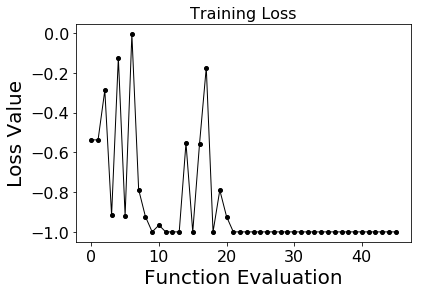

In [103]:
# Visualize loss across function evaluations
fig = plt.figure(figsize=(6, 4))
plt.plot(qae.train_history, 'ko-', markersize=4, linewidth=1)
plt.title("Training Loss", fontsize=16)
plt.xlabel("Function Evaluation",fontsize=20)
plt.ylabel("Loss Value", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

## Testing

Now test the optimized network against the rest of the data set (i.e. use the optimized parameters to try to compress then recover each test data point).

In [104]:
avg_loss_test = qae.predict()

Iter   46 Mean Loss: -0.9999438
Mean loss for test data: -0.9999437500000001


# Noise Library (ES 170 Project)

Now we will give our generalized noise library. This library can generate a noise model for the entire range of gates in the Pyquil library.

To do this, we first compile our code down to Pyquil's native gates. After this, we parse these gates and generate a string that can be inputted into our Mathematica notebook.  The user can vary the noise parameters in the Rx, Rz, and Cz gates. By fixing one of these variables, the user can see the visualize the affect of two of these noisy gates on their program via a 3D graph. 

## Parsing the executable Circuit

In this function we parse the executable circuit outputted by Pyquil. This function will output a list of Rx, Rz, and Cz gates with the correct angles, control and target bits that our higher level gates (such as Hadamard) compiled down to. 

In [1]:
# Number of qubits in our circuit 
# Vary this parameter if you are using our libarary on a circuit with a different number of qubits
N = 2

In [2]:
def compiled_formatting(p):
    temp = str(executable)
    gates = []
    # get the gate strings our of the excutable program string
    for i in range(0, len(temp)):
        # look for line breaks 
        if(temp[i] == "n"): 
            # look for RZ and RX gates
            if temp[i+1] == 'R':
                if temp[i+2] == 'X' or temp[i+2] == 'Z':
                    gates.append([])
            # look for CZ gates
            if temp[i+1] == 'C' and temp[i+2] == 'Z':
                    gates.append([])
        elif len(gates) > 0:
            gates[len(gates)-1].append(temp[i])

    # reformat the gate strings so that they are easy to use
    n_gates = []
    
    for i in range(0, len(gates)):
        # reformat RX and RZ gates
        if gates[i][0] == 'R':
            # append the correct angle (+/- pi/2) and target bit for the RX gate
            if gates[i][1] == 'X':
                if '-' in gates[i]:
                    bit = gates[i][-2]
                    n_gates.append(['RX', '-Pi/2', bit])
                else:
                    bit = gates[i][-2]
                    n_gates.append(['RX', 'Pi/2', bit])
            # append the correct angle and target bit for the RZ gate
            if gates[i][1] == 'Z':
                count = 3
                angle = ""
                # reformat the angle value for RZ gate
                while(gates[i][count] != ')'):
                    angle += gates[i][count]
                    count += 1
                bit = gates[i][-2]
                # account for negative angles
                if '-' in angle:
                    angle = angle[1:]
                    if angle == 'pi':
                        n_gates.append(['RZ', '-Pi', bit])
                    elif angle == 'pi/2':
                        n_gates.append(['RZ', '-Pi/2', bit])
                    else:
                        n_gates.append(['RZ', f'-{angle}', bit])
                elif angle == 'pi':
                    n_gates.append(['RZ', 'Pi', bit])
                elif angle == 'pi/2':
                    n_gates.append(['RZ', 'Pi/2', bit])
                else:
                    n_gates.append(['RZ', angle, bit])
        # append the correct control and target bits for the CZ gate
        elif gates[i][0] == 'C':
            control_bit = gates[i][-4]
            target_bit = gates[i][-2]
            n_gates.append(['CZ', control_bit, target_bit])
        # Reformat the last gate to ensure that it has the correct target (and/or control) bits
        if i == len(gates)-1:
            count = 0
            while(gates[i][count] != '\\'):
                count += 1
            if n_gates[i][0] == 'RZ' or n_gates[i][0] == 'RX':
                n_gates[i][2] = gates[i][count-1]
            if n_gates[i][0] == 'CZ':
                n_gates[i][1] = gates[i][count-3]
                n_gates[i][2] = gates[i][count-1]
    
    # ensure that we will do the matrix multiplication in the correct order
    n_gates.reverse()
    return n_gates

## Create Rx, Rz, and Cz noisy gates 

The following code adds noise parameters, x, z, c to our standard gates, where each parameter is in term of an angle. In order to see the effect of varying these parameters, we want to retain the symbolic representation of these matrices, that we can multiply out in the Mathematica notebook. The following code prepares the symbolic notation for these gates as well as formats the program to be inputted to the Mathematica notebook.

### Standard function for Cz gate permutations

In [3]:
from itertools import permutations
from qutip import Qobj

# Build permutation maps for Cz matrix generation
def gen_permute_orderings(n):
    # n = number of qubits
    orderings = {}
    for p in permutations(range(n)):
        m = [list(range(1, 1 + 2 ** n))] * (2 ** n)
        m = Qobj(m)
        m.dims = [[2] * n] * 2
        m_perm = m.permute(p)
        orderings[p] = list(map(int, np.real(m_perm.full()[0])))
    return orderings

_permute_orderings = gen_permute_orderings(N)
# Format string for Mathematica notebook
def permute(m, p):
    order = f'{{{",".join(map(str, _permute_orderings[tuple(p)]))}}}'
    return f'Transpose[Permute[Transpose[Permute[{m}, {order}]], {order}]]'

NameError: name 'np' is not defined

### Format strings functions to output Mathematica program

In [ ]:
import numpy as np

from qutip.qip.gates import rx, rz, controlled_gate

# gate structure: https://www.quantum-inspire.com/kbase/rotation-operators
# format strings for each of the gates and operations used in Mathemaica notesbook
IDENTITY = 'IdentityMatrix[2]'
RZ_2QUBIT = '{{E^(-I (THETA + z) / 2.0), 0}, {0, E^(I (THETA + z) / 2.0)}}'
RX_2QUBIT = '{{Cos[(THETA + x) / 2.0], -I Sin[(THETA + x) / 2.0]}, {-I Sin[(THETA + x) / 2.0], Cos[(THETA + x) / 2.0]}}'

CZ_2Q_C0_T1 = '{{1,0,0,0},{0,1,0,0},{0,0,-E^(I (2 Pi + c)/2.0),0},{0,0,0,E^(I (2 Pi + c)/2.0)}}'
CZ_2Q_C1_T0 = '{{1,0,0,0},{0,-E^(I (2 Pi + c)/2.0),0,0},{0,0,1,0},{0,0,0,E^(I (2 Pi + c)/2.0)}}'
czTop = '-E^(I (2 Pi + c)/2.0)'
czBottom = 'E^(I (2 Pi + c)/2.0)'

MULTIPLY = '.('

FOCK_20 = '{{1.0,0.0},{0.0,0.0}}'
FOCK_21 = '{{0.0,0.0},{0.0,1.0}}'


ZEROKET = f'{{{",".join(["{1}"] + (["{0}"] * (-1 + 2**N)))}}}'

def tensor(*args):
    # notation to tensor matrices in Mathematica
    assert(len(args) > 0)
    if len(args) == 1:
        return args[0]
    return f'KroneckerProduct[{",".join(args)}]'

def add(*args):
    # notation to add matrices in Mathematica
    return ' + '.join(args)

def make_rx(gate_params, n):
    # creates the symbolic version of the noisy Rx gate
    name, theta, target = gate_params
    target = int(target)
    assert(name == 'RX')
    
    rx_2q = RX_2QUBIT.replace('THETA', theta)
    return tensor(*[(rx_2q if i == target else IDENTITY) for i in range(n)])

def make_rz(gate_params, n):
    # creates the symbolic version of the noisy Rz gate
    name, theta, target = gate_params
    target = int(target)
    assert(name == 'RZ')
    
    rz_2q = RZ_2QUBIT.replace('THETA', theta)
    return tensor(*[(rz_2q if i == target else IDENTITY) for i in range(n)])


# Creates a 2-qubit CZ gate
def make_cz(gate_params, n):
    name, control, target = gate_params
    assert(name == "CZ")
    assert(n == 2)
    
    if control == '0' and target == '1':
        return CZ_2Q_C0_T1
    elif control == '1' and target == '0':
        return CZ_2Q_C1_T0
    else:
        assert(1 == 0)

#Creates an n-qubit CZ gate with any control and target qubits
def make_czFull(gate_params, n): 
    name, c, t = gate_params
    assert(name == "CZ")
    z = Qobj([[2,0],[0,3]])
    cZ = controlled_gate(z, N = n, control = c, target = t)
    mString = "{"
    for e in cZ: 
        mString += "{"
        for n in e[0]:
            if(n == 2.0): 
                mString += czTop.replace('THETA', 'PI') + ", "
            elif(n == 3.0): 
                mString += czBottom.replace('THETA', 'PI') + ", "
            else: 
                mString += str(np.real(n)) + " + " + str(np.imag(n)) + "I, "
        mString = mString[:len(mString) - 2]
        mString += "},"
    mString = mString = mString[:len(mString) - 2] + "}}"
    return mString


GATE_MAP = {
    'RX': make_rx,
    'RZ': make_rz,
    'CZ': make_cz,
}


def fix_order(ket):
    # flips order of qubits (pyquil uses IBM style)
    return f'{ket}[[{{1, 3, 2, 4}}]]'

def measure_probs(ket):
    #measures probabilities of each state in wavefunction
    return f'Map[Norm[#]^2 &, {ket}, {{2}}]'

def make_vector(nprn):
    #constructs necessary vector
    return ZEROKET + ')' * nprn

def converttoMathematicaVector(wF): 
    #converts an array of wavefunction amplitudes generated using the WaveFunctionSimulator into a mathematica vector
    mString = "{"
    for e in wF: 
        realVal = str(np.real(e))
        erealInd = realVal.find('e')
        imagVal = str(np.imag(e))
        eimagInd = imagVal.find('e')
        if(erealInd != -1): 
            re = realVal[:erealInd]
            exponentR = realVal[erealInd+1:]
            re += " * 10^" + exponentR
        else: 
            re = realVal
        if(eimagInd != -1): 
            im = imagVal[:eimagInd]
            exponentI = imagVal[eimagInd+1:]
            im += " * 10^" + exponentR
        else: 
            im = imagVal
        mString += "{" + re + " + (" + im + ")I" + "},"
    mString = mString[:len(mString) -1] + "}"
    return mString
    
    
def make_error_function(gates, n, ideal_state):
    # returns function to be used in Mathematica
    # n: number of qubits
    str_gates = ['(']
    for gate in gates:
        str_gates.append(GATE_MAP[gate[0]](gate, n))
    vec = make_vector(len(gates)+1)
    str_gates.append(vec)
    temp = MULTIPLY.join(str_gates)
    # reformat to fix multiplication string with  first gate
    temp = temp[2:]
    
    ideal_state = map(lambda num: f'{{{num}}}', ideal_state)
    ideal_state_str = f'{{{",".join(ideal_state)}}}'.replace('j', 'I')
    
    noisy_probs = fix_order(measure_probs(temp))
    ideal_probs = measure_probs(ideal_state_str)
    
    return f'ErrorFunc[x_, z_, c_] = Norm[{noisy_probs} - {ideal_probs}]'


# Testing our Noise Functions on qCompress

In the following code, we test our noise function on the trained qCompress circuit. We initalize a program and select a preocmputed state_prep circuit. We run the half of the circuit (state prep and compression), with and without our noisy parameters. The outputted string, should be copied and pasted into our Mathematica notebook for analysis.

In [4]:
# Choose from list of precomputed state_prep circuits
index = 8

# Initializes program
noisy_qvm = get_qc('9q-qvm')
p = Program()

# Runs half circuit
circ_input = qae.state_prep_circuits[index]
p.inst(circ_input)
circ_compress = qae.construct_compression_circuit(qae.optimized_params, index)
p.inst(circ_compress)

# Expected vector for non-noisy computation 
wfs = WavefunctionSimulator()
wf = wfs.wavefunction(p)
ideal_state = wf.amplitudes

# Compute formula for noisy computation
executable = noisy_qvm.compile(p)
gates = compiled_formatting(executable)
mathematica_str = make_error_function(gates, 2, ideal_state)
print(mathematica_str)

NameError: name 'get_qc' is not defined